# Predict electricity demand with GluonTS


## Contents

1. [Introduction](#1.-Introduction)
2. [Problem Definition](#2.-Problem-Definition)
3. [Architecture design](#3.-Architecture-design)
4. [Data Discovery](#4.-Data-Discovery)
5. [Machine Learning Models](#5.-Machine-Learning-Models)
6. [Prepare the Model Artifacts for Deployment](#6.-Prepare-the-Model-Artifacts-for-Deployment)

---

# 1. Introduction

Time series forecasting is a common problem in many real-world applications. There are a wide spectrum of algorithms that can be used to solve time series problems. The Amazon Forecast Service provides several machine learning algorithms, including ARIMA, DeepAR+, and Prophet. Also, SageMaker provides DeepAR as a first party algorithm that can be used for time series forecasting. For some use cases, organisations may need to take advantage of new time series algorithms not available in these services or create custom algorithms that meet their business goals.

In this tutorial, we will walk through some of the most widely used time series algorithms and demonstrate how to train, evaluate and deploy them to the AWS cloud. [Gluon Time Series (GluonTS)](https://gluon-ts.mxnet.io/) is the Gluon toolkit for probabilistic time series modeling, focusing on deep learning-based models. Using GluonTS, we will walk through how to prepare the data, create a baseline model, and then train several candidate models for evaluation.

In the second part of this tutorial, we will walk through the productionization steps and use SageMaker custom containers to deploy the multiple models that have been trained to a single endpoint.

## Why is resource forecasting important?

A common problem in many organisations is the need to accurately predict resource
demand in order to proactively up scale and down scale supply to minimize costs
while maintaining adequate service. Within AWS, it is essential to the cost-efficient
provisioning of resources like compute and storage.

<figure>
<img src="images/console_ec2_usage_report_graph_3.png" width="600px" alt="An Example of resource utlisation planning in AWS"/>
<figcaption> An Example of resource utlisation planning in AWS (https://aws.amazon.com/blogs/aws/amazon-ec2-instance-usage-and-reserved-instance-utilization-reports/)</figcaption>
</figure>


This is also important within utility providers for gas, electricity, water or broadband. With predictive model that
works for individual consumers, resource providers can execute pre-emptive actions that will avoid under or over supply. A good example of this is electricity supply. With the ability to predict individual household demand, a utility could create targeted incentives to households to bring demand down for anticipated peaks, better plan maintenance windows, or provide direct household feed-back on projected utilization via dashboards. Predictions can also be aggregated to provide signals for turning on and off additional power sources that have long start up times.

<figure>
<img src="images/electric_power_meter.jpg" width="600px" alt="Electric Power Meter by La Chachalaca Fotografía is licensed under CC BY-NC 2.0"/>
<figcaption> Electric Power Meter by La Chachalaca Fotografía is licensed under CC BY-NC 2.0 (https://www.flickr.com/photos/21175949@N03)</figcaption>
</figure>

# 2. Problem Definition

A local utility utilizes gas fired generators to provide additional electricity during peak demand times and needs to have a 2 hour lead time to start up additional gas powered electricity production. It also wishes to provide live predictions via a mobile app to consumers of daily predicted electricity usage.

From this problem, we can pull out some key features of the machine learning model:

- The frequency of the demand data needs to transformed to every 2 hours.
- Forecasts should be calculated every 2 hours.
- The model needs to forecast the next 24 hours. This is the forecast horizon.
- No prediction method currently exists for comparison, so we need to create baseline models to evaluate our model against.

## General Approach
Now that we have defined the problem, here are the steps needed:

- Withhold the last 24 hours of data as a test data set, and use the previous
time series as training data.
- We will train several machine learning models for comparison: methods,
statistical methods, to deep learning-based methods as below:

    - [Mean](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.trivial.mean.html): Uses the mean in the training data to predict the next 24 hours.
    - [Seasonal Naive](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.seasonal_naive.html): Uses the last 24-hour observations to predict the next 24 hours.
    - [Exponential smoothing (ETS)](https://www.rdocumentation.org/packages/forecast/versions/8.12/topics/ets): Uses the weighted combinations of past observations to predict the next 24 hours.
    - [Prophet](https://facebook.github.io/prophet/): Forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.
    - [DeepAR](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html): Probabilistic forecasting with autoregressive recurrent networks.

- Model will be deployed as Amazon SageMaker endpoints using the multi-model endpoint functionality to provide real-time forecasting.

# 3. Architecture design

The architecture required for this project is split into two main areas, model development and model deployment. The development of the models is done within Amazon SageMaker Notebooks. Within the notebook, we perform feature engineering and model training and evaluation with GluonTS. Amazon Simple Storage Service (S3) is used for storing all of our trained models.

For the second part of this tutorial, we will build a docker container that will be used when deploying multiple models.

The Amazon Elastic Container Registry (ECR) is used to store our developed docker
container. The multiple models are then deployed using an Amazon SageMaker endpoint.

![01_arch_design_1](images/gluonts_sagemaker.png)

# 4. Data Discovery

For this tutorial, we will forecast individual household electricity demand using the "Individual household electric power consumption" data set that is publicly available from [University of California Irvine Machine Learning Repository (UCI-MLR)](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption). We have a simple Python function in `project_dependencies.py` that will download this file from the UCI-ML repository to our local notebook so we can use it for training and evaluation.

## Import project dependencies
Before beggining, first import all the python modules, download the data, configuration settings and helper functions needed. 

> **Note:** When developing your own projects, it's recommended to separate lower level code out to a python module to make the notebook more readable. This also makes putting the final code into production format easier as it is already partly modularized.

In [1]:
from project_dependencies import *

File found skipping download


## Feature Engineering

As mentioned in the previous tutorial, Feature engineering is the process of transforming raw data into features that can be used for training and testing a machine learning model. Time series data can be stored in various format, can have missing values or may be captured at a higher or lower frquency than what is needed. In addition, machine learning algorithms require the data be put in a standard format for both training and inference. The main steps taken to format the raw data are outlined here.

### Step 1: Read raw data
Since we have downloaded the data to local disk now, then we read the data into an in-memory Pandas data frame. Pandas is a data science library that makes it easy to process and explore time series data. Using the Pandas csv function the query results can be read directly into an in memory data frame. 

> **Explore:** For more information on working with Pandas, check out the  [user guide](https://pandas.pydata.org/docs/user_guide/index.html).

In [2]:
data = pd.read_csv(FILE_PATH, sep=";", index_col=0, parse_dates=True, decimal=',')

### Step 2: Exploratory Data analysis
We can do some data analysis as below:
- check the basic statistics of the data.
- check what is the frequency of the data.
- check date ranges of the time series.

In [3]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


In [4]:
data.index

DatetimeIndex(['2011-01-01 00:15:00', '2011-01-01 00:30:00',
               '2011-01-01 00:45:00', '2011-01-01 01:00:00',
               '2011-01-01 01:15:00', '2011-01-01 01:30:00',
               '2011-01-01 01:45:00', '2011-01-01 02:00:00',
               '2011-01-01 02:15:00', '2011-01-01 02:30:00',
               ...
               '2014-12-31 21:45:00', '2014-12-31 22:00:00',
               '2014-12-31 22:15:00', '2014-12-31 22:30:00',
               '2014-12-31 22:45:00', '2014-12-31 23:00:00',
               '2014-12-31 23:15:00', '2014-12-31 23:30:00',
               '2014-12-31 23:45:00', '2015-01-01 00:00:00'],
              dtype='datetime64[ns]', length=140256, freq=None)

In [5]:
data.index.min(), data.index.max()

(Timestamp('2011-01-01 00:15:00'), Timestamp('2015-01-01 00:00:00'))

As we can see from the data is across four years from `2011-01-01` to `2015-01-01`. The data quality is quite good and the electricity time series are sampled `every 15 mintues`.

### Step 3: Downsample to 2-hour samples by sum value
As we mentioned before, we are only interested in forecasting the granularity of every 2 hours. Thus, we resample the data to the frequency of 2 hours. 

In [6]:
num_timeseries = data.shape[1]
data_kw = data.resample('2H').sum() / 8

In [7]:
data_kw.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check if there is any missing values.

In [8]:
data_kw.isna().sum().sum()

0

There is no missing values, so further processing is needed here. 

### Step 4: Visualization: Plot some sample time series

Use the magic function in IPython to make your plot outputs appear and be stored within the notebook.

In [9]:
%matplotlib inline

Transform the data frame to list of time series below for plotting.

In [10]:
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:,i], trim='f'))

Use the `matplotlib` libary to plot 10 different individual time series as below. We can see some time series have strong daily pattern while others have relatively irregular patterns.

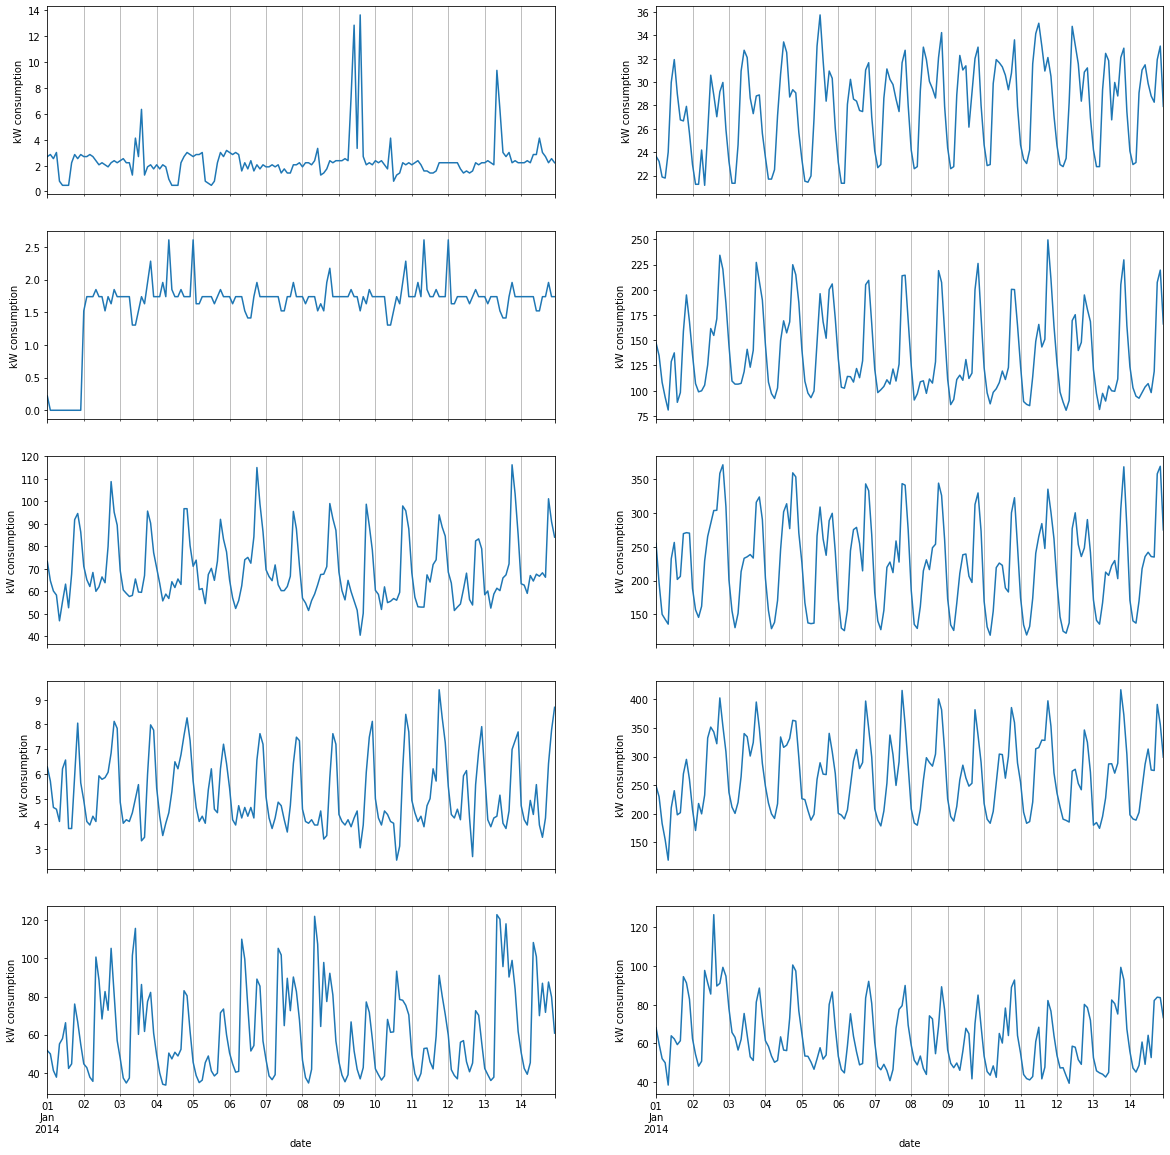

In [11]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2014-01-01":"2014-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("kW consumption")   
    axx[i].grid(which='minor', axis='x')

### Step 5: Split data into training and a test sets
In order to evaluate the final model, the data needs to be split into training and test sets. To accurately get an idea of how the model will perform on previously unseen data, time series data should be split according to a cutoff date.

![training and test split by time](images/train_test_split.png)

We defined a function `split_train_test_data` in `project_dependencies.py` to split the data based on a cutoff date and transform the training and test data sets into the required format by the GluonTS library.

In [12]:
training_data, test_data = split_train_test_data(timeseries[:n_timeseries],
                          start_training,
                          end_training,
                          num_test_windows)

## 4.3 Save data

We save the train and test data both locally and on S3 for later use.

In [13]:
write_dicts_to_file(os.path.join(output_dir, 'train.json'), training_data)
upload_to_s3(bucket, prefix, os.path.join(output_dir, 'train.json'))
write_dicts_to_file(os.path.join(output_dir, 'test.json'), test_data)
upload_to_s3(bucket, prefix, os.path.join(output_dir, 'test.json'))

# 5. Machine Learning Models

## 5.1 Training and Testing

We defined a function `train_and_test` in `project_dependencies.py` to perform the following steps:

- Train the model using the training data set.
- Save the trained model to local disk for later deployment.
- Perform forecasting on the test data set.

We repeat the above steps for each model as below.

### Mean

An model that computes the mean targets in the training data, in the trailing `prediction_length` observations, and produces a [ConstantPredictor](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.trivial.constant.html) that always predicts such mean value. Pls refer to [link](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.trivial.mean.html) for more details.

In [14]:
%%time
mean= MeanPredictor(freq=freq, prediction_length=prediction_length,
                                  context_length=context_length)
forecasts_mean, tss_mean = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               mean,
               require_train=False
               )

CPU times: user 103 ms, sys: 3.69 ms, total: 107 ms
Wall time: 106 ms


### Seasonal Naive

For each time series 𝑦, this predictor produces a forecast  𝑦̃ (𝑇+𝑘)=𝑦(𝑇+𝑘−ℎ) , where  𝑇  is the forecast time,  𝑘=0,...,  prediction_length - 1, and  ℎ=  season_length. Pls refer to [link](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.seasonal_naive.html) for more details.

In [15]:
%%time
seasonal = SeasonalNaivePredictor(freq=freq,
                                  prediction_length=prediction_length,
                                  season_length=prediction_length)
forecasts_seasonal, tss_seasonal = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               seasonal,
               require_train=False
               )

CPU times: user 70.9 ms, sys: 3.9 ms, total: 74.8 ms
Wall time: 73.6 ms


### ETS

Exponential smoothing (ETS, which stands for Error, Trend, and Seasonality) is a family of very successful forecasting methods which are based on the key property that forecasts are weighted combinations of past observations. Refer to [link](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.r_forecast.html) for more details.

In [16]:
%%time
ets = RForecastPredictor(freq=freq,
                           prediction_length=prediction_length,
                           method_name='ets',
                           )
forecasts_ets, tss_ets = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               ets,
               require_train=False
               )

CPU times: user 53.2 s, sys: 50.4 ms, total: 53.3 s
Wall time: 53.3 s


### Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. Pls refer to [link](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.prophet.html) for more details.

In [17]:
%%time
prophet = ProphetPredictor(freq, prediction_length)
forecasts_prophet, tss_prophet = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               prophet,
               require_train=False
               )

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

CPU times: user 36 s, sys: 335 ms, total: 36.3 s
Wall time: 36.1 s


### DeepAR

The DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN). Pls refer to [link](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html) for more details.

In [18]:
%%time
deepar = DeepAREstimator(freq=freq,
                         use_feat_static_cat=True,
                         cardinality=[n_timeseries],
                        prediction_length=prediction_length,
                        trainer=Trainer(epochs=100),
                        num_cells=40)
forecasts_deepar, tss_deepar = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               deepar,
               require_train=True
               )

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:gluonts.trainer:Number of parameters in DeepARTrainingNetwork: 40803


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:02<00:00, 22.22it/s, epoch=1/100, avg_epoch_loss=4.56]
INFO:gluonts.trainer:Epoch[0] Elapsed time 2.252 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=4.557352
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 23.77it/s, epoch=2/100, avg_epoch_loss=3.92]
INFO:gluonts.trainer:Epoch[1] Elapsed time 2.106 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=3.923174
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 23.79it/s, epoch=3/100, avg_epoch_loss=3.77]
INFO:gluonts.trainer:Epoch[2] Elapsed time 2.104 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=3.768079
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 23.78it/s, epoch=4/100, avg_epoch_loss=3.63]
INFO:gluonts.trainer:Epoch[3] Elapsed time 2.106 seconds
INFO:gluonts.trainer:Epoch[3] Evaluation metric 'epoch_loss'=3.627729
INFO:

CPU times: user 6min 10s, sys: 7.55 s, total: 6min 18s
Wall time: 3min 33s


## 5.2 Results

To evaluate the performance of the models, we select the evaluation metrics as below.

- [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation, also used as a loss function for regression problems in machine learning.

- [The root-mean-square deviation (RMSD)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) or root-mean-square error (RMSE) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed.

And compare the performance of the models.

### Performance Comparision
We first calculate the evaluation metrics for each model as below.

In [19]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_mean, item_metrics_mean = evaluator(iter(tss_mean), iter(forecasts_mean), num_series=len(forecasts_mean))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 1152.28it/s]


In [20]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_seasonal, item_metrics_seasonal = evaluator(iter(tss_seasonal), 
                                                        iter(forecasts_seasonal), 
                                                        num_series=len(forecasts_seasonal))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 1502.61it/s]


In [21]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_ets, item_metrics_ets = evaluator(iter(tss_ets), 
                                                        iter(forecasts_ets), 
                                                        num_series=len(forecasts_ets))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 1508.31it/s]


In [22]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_prophet, item_metrics_prophet = evaluator(iter(tss_prophet), 
                                                        iter(forecasts_prophet), 
                                                        num_series=len(forecasts_prophet))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 1468.76it/s]


In [23]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_deepar, item_metrics_deepar = evaluator(iter(tss_deepar), 
                                                        iter(forecasts_deepar), 
                                                        num_series=len(forecasts_deepar))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 1425.27it/s]


Then we compare the evaluation metrics for all the models.

In [24]:
df_metrics = pd.concat(
    [
        pd.DataFrame.from_dict(agg_metrics_deepar, orient='index').rename(columns={0: "DeepAR"}),
     pd.DataFrame.from_dict(agg_metrics_prophet, orient='index').rename(columns={0: "Prophet"}),
     pd.DataFrame.from_dict(agg_metrics_ets, orient='index').rename(columns={0: "ETS"}),
    pd.DataFrame.from_dict(agg_metrics_seasonal, orient='index').rename(columns={0: "Seasonal naive"}),
    pd.DataFrame.from_dict(agg_metrics_mean, orient='index').rename(columns={0: "Mean"})], axis=1
)
df_metrics.loc[["RMSE", "MAPE"]]

,DeepAR,Prophet,ETS,Seasonal naive,Mean
RMSE,24.029905,26.535960,29.460621,29.184250,103.638603
MAPE,0.080550,0.117399,0.116969,0.090301,0.321909


We can see the `DeepAR` model performs the best in terms of both evaluation metrics.

### Visualization: Plot Example Forecast

Also, to give a sense of how the forecast compared to the actual demand, we plot some example forecast vs actual charts for the models as below.

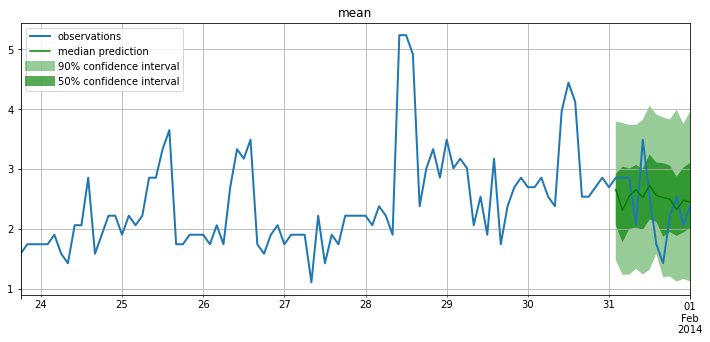

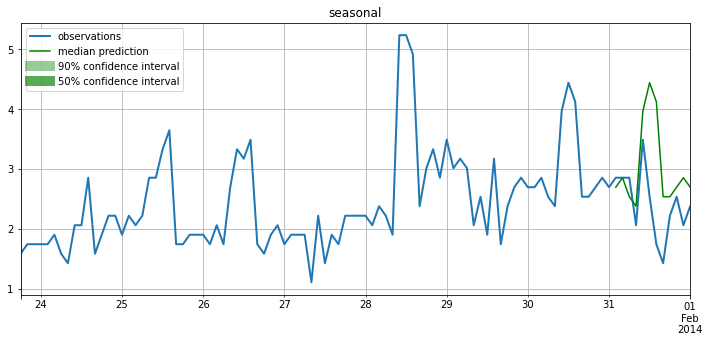

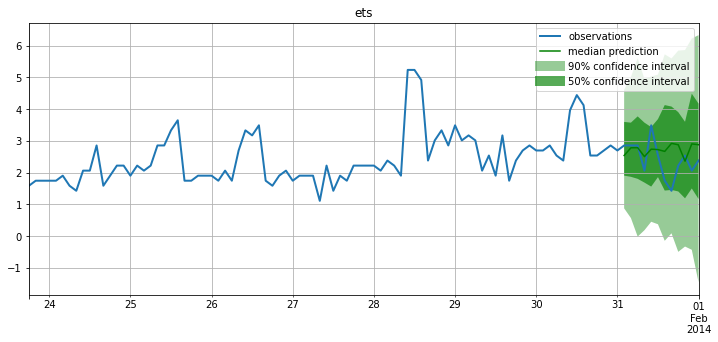

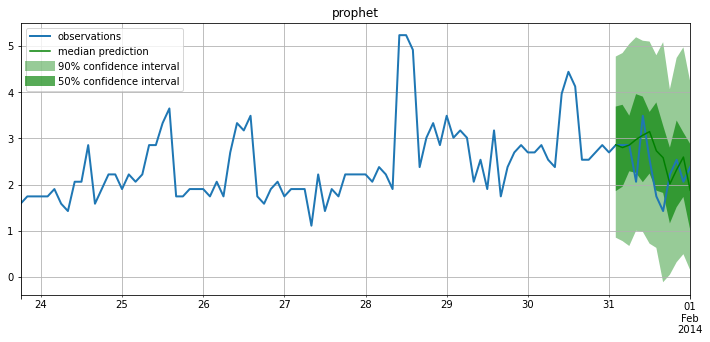

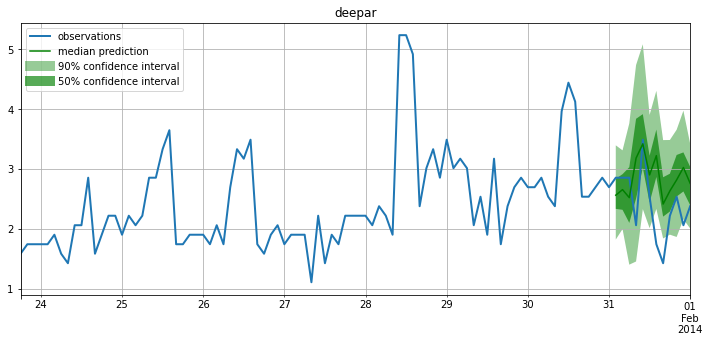

In [25]:
start, stop, step = 0, 1, 1
plot_forecasts(tss_mean, forecasts_mean, past_length=100, start=start, stop=stop, step=step, title="mean")
plot_forecasts(tss_seasonal, forecasts_seasonal, past_length=100, start=start, stop=stop, step=step, title="seasonal")
plot_forecasts(tss_ets, forecasts_ets, past_length=100, start=start, stop=stop, step=step, title="ets")
plot_forecasts(tss_prophet, forecasts_prophet, past_length=100, start=start, stop=stop, step=step, title="prophet")
plot_forecasts(tss_deepar, forecasts_deepar, past_length=100, start=start, stop=stop, step=step, title="deepar")

# 6. Prepare the Model Artifacts for Deployment

## Upload model artifacts to S3
In order to deploy the models to the Sagemaker endpoint, first we need to compress the model to .tar.gz format.

In [26]:
model_list = [
    "DeepAREstimator",
    "MeanPredictor",
    "ProphetPredictor",
    "RForecastPredictor",
    "SeasonalNaivePredictor",
]
for model in model_list:
    with tarfile.open(models_dir + '/' + model +'.tar.gz', 'w:gz') as tar:
        tar.add(models_dir + '/' + model, arcname='.')

Then, we need to upload them to S3.

In [27]:
for model in model_list:
    key = os.path.join(prefix, models_dir + '/' + model + '.tar.gz')
    with open(models_dir + '/' + model +'.tar.gz', 'rb') as file_obj:
        s3.Bucket(bucket).Object(key).upload_fileobj(file_obj)

## Deploy models with SageMaker

The [second part of this lab](2_Predict_electricity_demand_with_the_GluonTS_and_SageMaker_custom_containers/02_deploy_gluonts_forecast_models_as_multi_model_endpoints.ipynb) will walk through how to deploy all of these models to SageMaker as a multiple model endpoint. 